In [183]:
from warnings import filterwarnings
filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [184]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [185]:
data.shape

(62, 1)

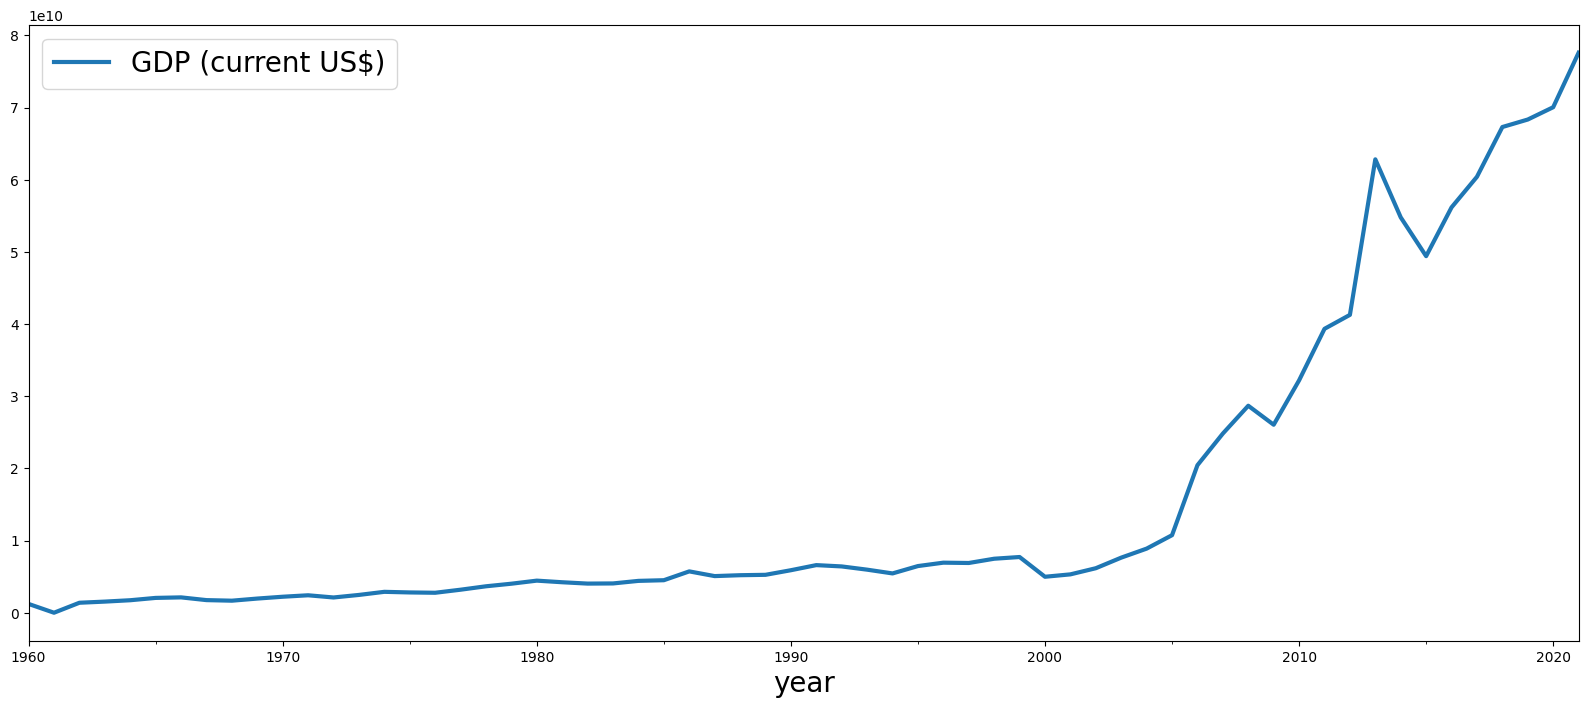

In [186]:
plt.rcParams["figure.figsize"] = 20, 8
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

#### В данных хорошо прослеживается возрастающий тренд. Про сезонность ничего сказать не могу

In [187]:
data.tail(3)

,GDP (current US$)
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [188]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

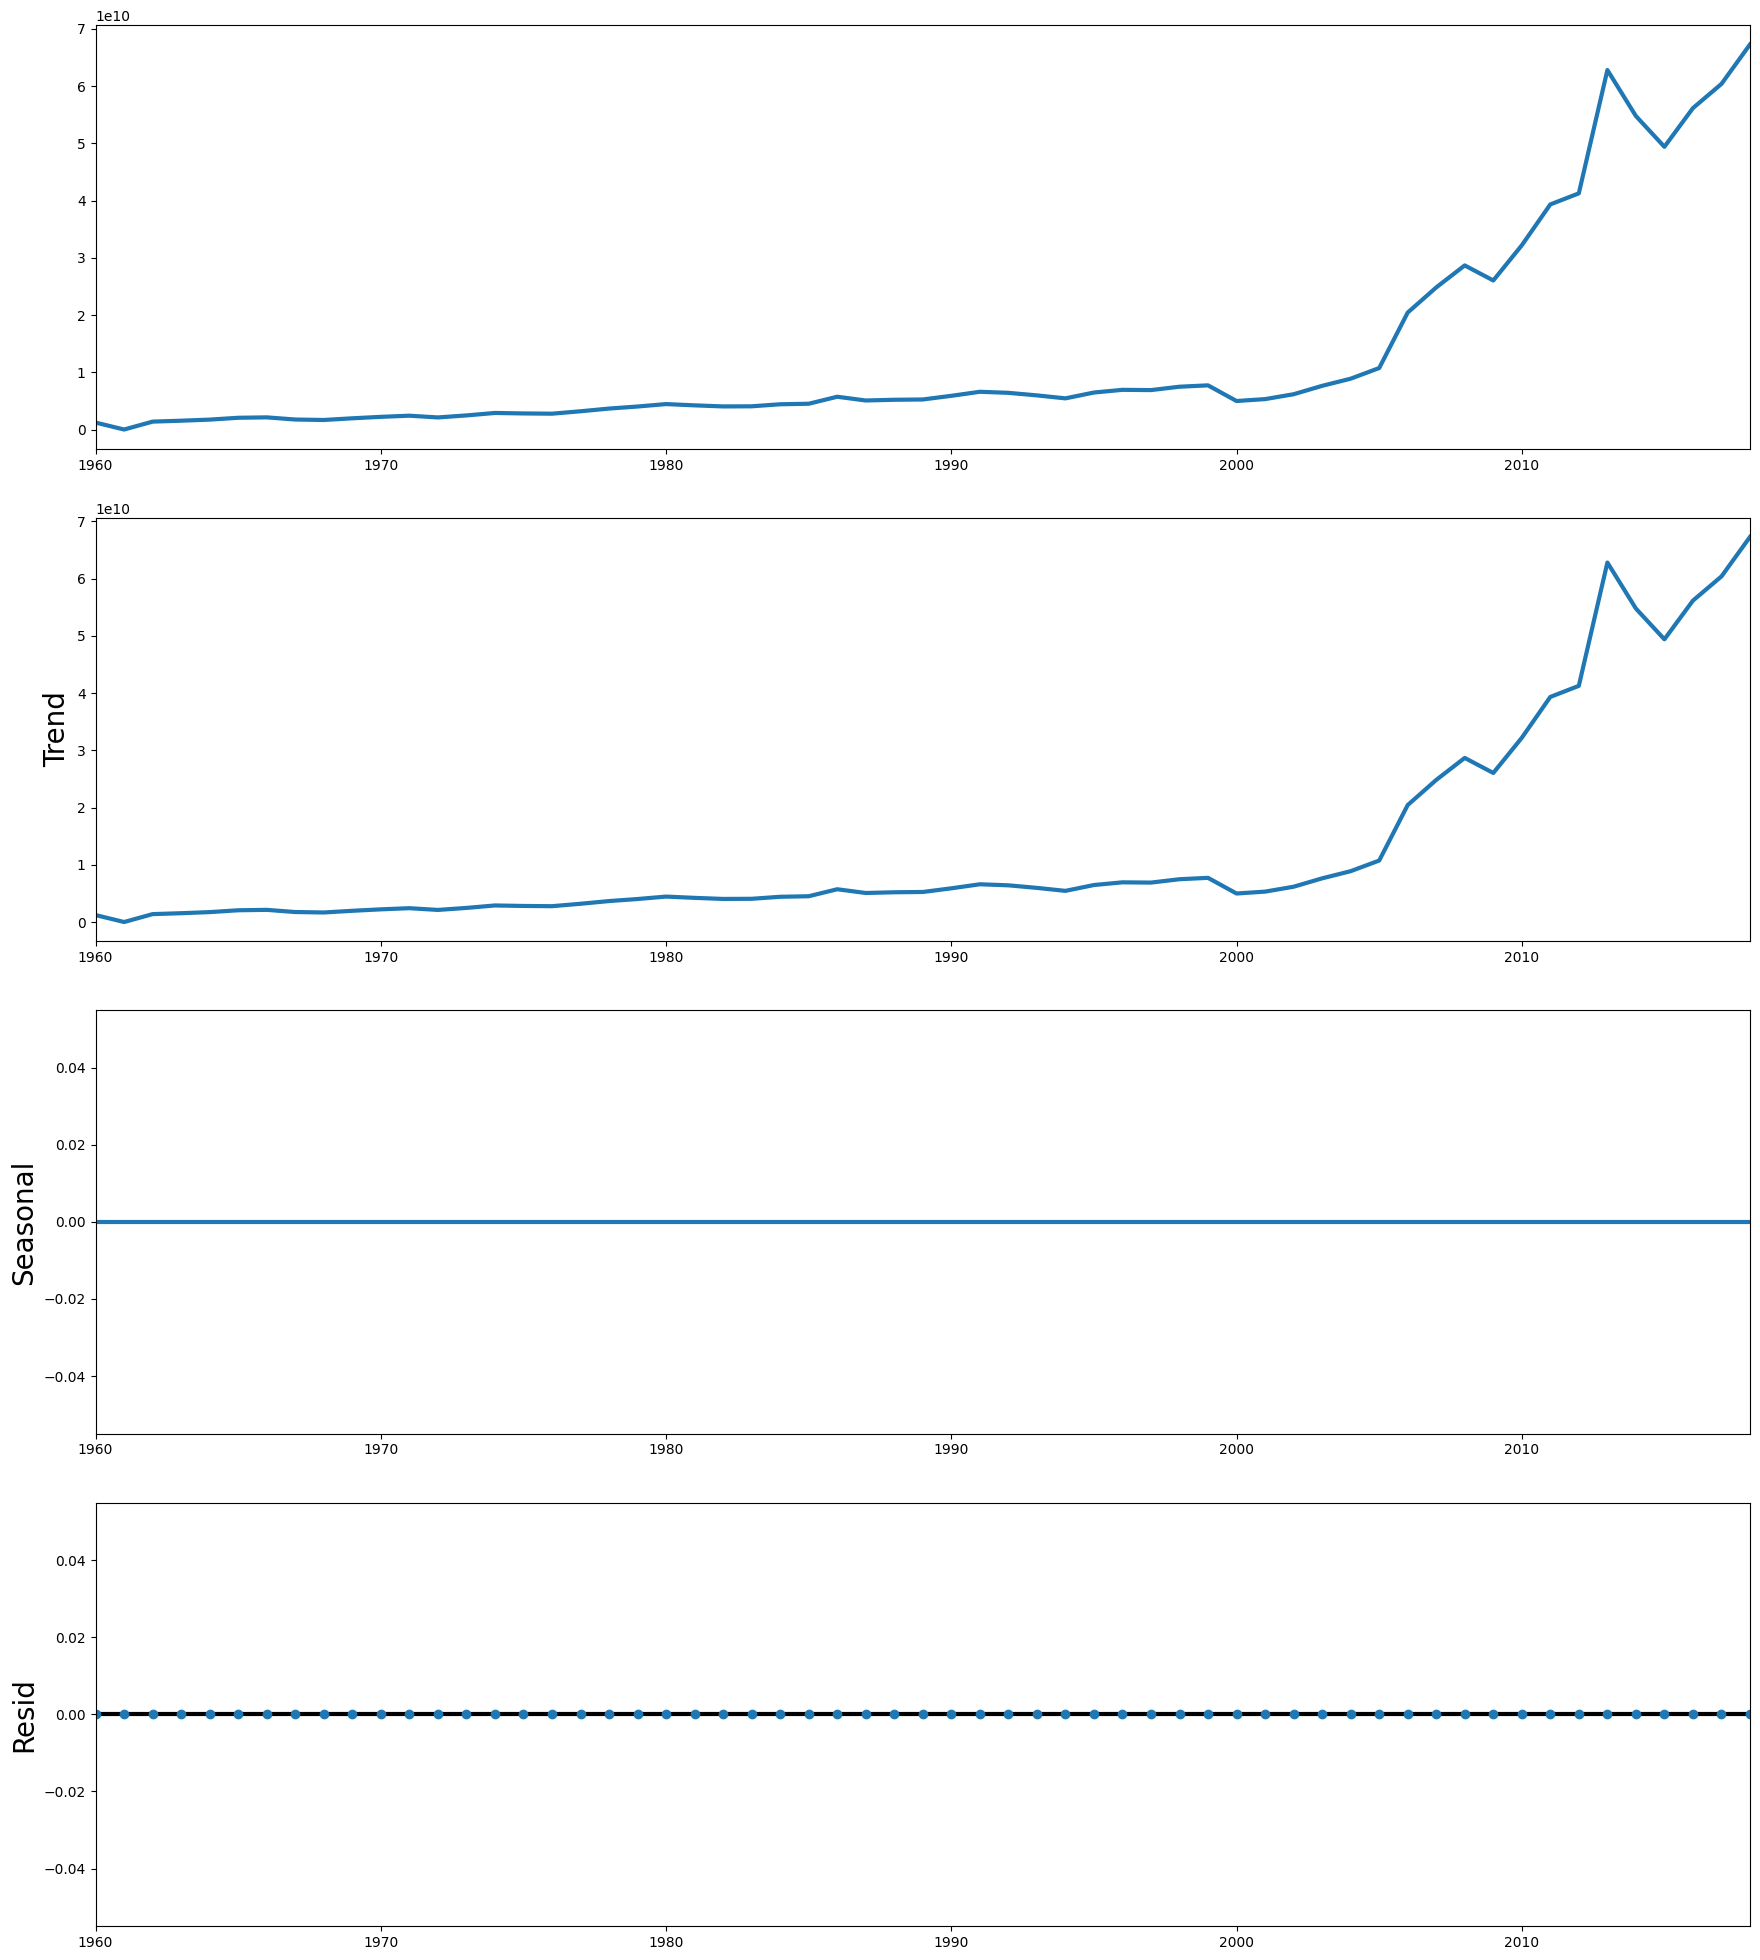

In [189]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df)
result.plot()
plt.show()

#### Сезонность в данных не прослеживается

### Скользящее среднее

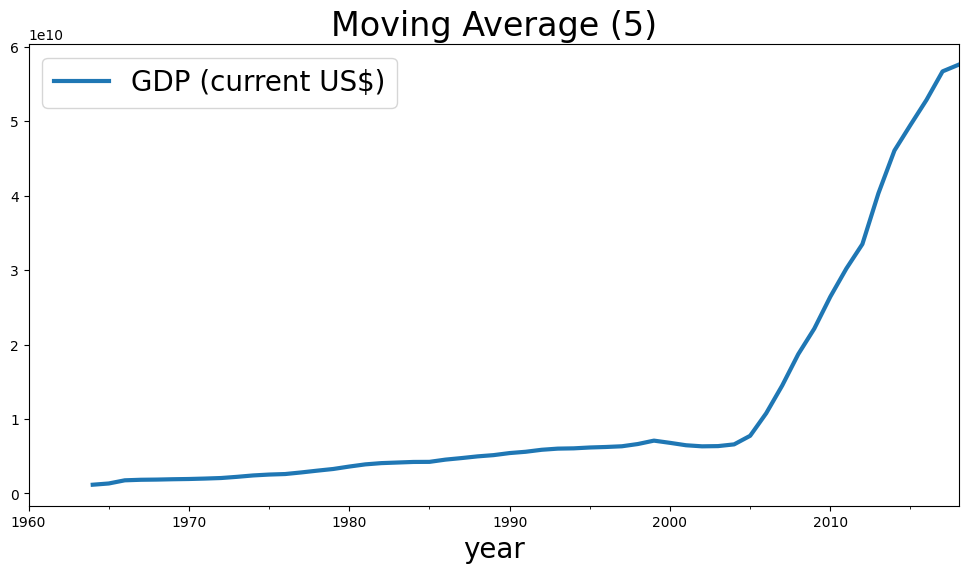

In [190]:
plt.rcParams["figure.figsize"] = 12, 6
train_df.rolling(window=5).mean().plot().set_title("Moving Average (5)")
plt.show()

#### В сравнении с исходным временным рядом и графиком скользящего среднего с окном в 5 лет наблюдаем тот же самый тренд. С уменьшением окна он прослеживается еще четче

# Тест на стационарность:

In [191]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["GDP (current US$)"])

(0.6529066974885391,
 0.9888496277665573,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

In [192]:
test1 = adfuller(train_df["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885391
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [193]:
import statsmodels.graphics.tsaplots as sgt
# Функция для построения графиков полной и частичной автокорреляции
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1], method="ywm")
    plt.show()

## Дифференцирование ряда

In [194]:
test1 = adfuller(train_df["GDP (current US$)"].diff(2).dropna())
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -3.583670865826027
p-value:  0.006080989753877
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


### Вторые разности являются стационарными

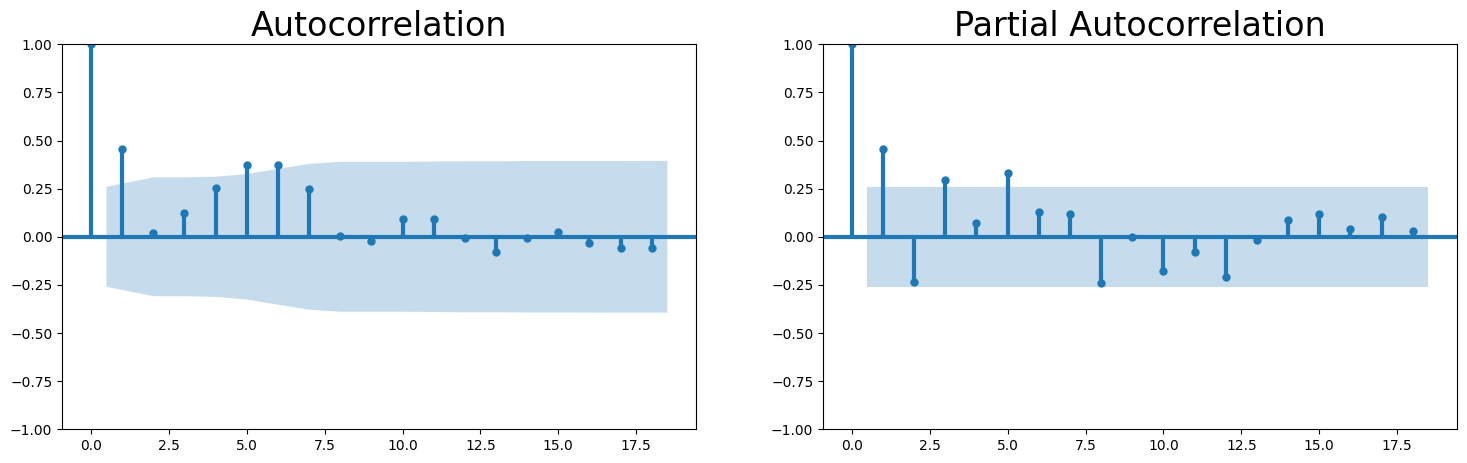

In [195]:
plot_acf_pacf(train_df["GDP (current US$)"].diff(2).dropna())

#### Временной ряд не стационарен в качестве модели выбираем ARIMA, p=5, q = 6, d=2

In [196]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(5, 2, 6))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 2, 6)   Log Likelihood               -1329.251
Date:                Mon, 11 Sep 2023   AIC                           2682.502
Time:                        16:33:53   BIC                           2707.019
Sample:                    01-01-1960   HQIC                          2692.030
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2420      9.427     -0.026      0.980     -18.719      18.235
ar.L2          0.7146      5.444      0.131      0.896      -9.956      11.385
ar.L3          0.0061      3.544      0.002      0.999      -6.940       6.952
ar.L4         -0.3692      2.427     -0.152      0.879      -5.127       4.388
ar.L5          0.2825      6.108      0.046      0.963     -11.689      12.254
ma.L1         -0.6929      9.549     -0.073      0.942     -19.409      18.024
ma.L2         -1.3950      3.491     -0.400      0.689      -8.236       5.446
ma.L3          1.3475     12.470      0.108      0.914     -23.093      25.788
ma.L4          0.5512     10.290      0.054      0.957     -19.617      20.719
ma.L5         -0.7484      5.872     -0.127      0.899     -12.257      10.760
ma.L6          0.0055      6.071      0.001      0.999     -11.894      11.905
sigma2      1.542e+19   6.81e-18   2.26e+36      0.000    1.54e+19    1.54e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                89.59
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              75.40   Skew:                             1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.53e+53. Standard errors may be unstable.
"""

In [197]:
#pip install pmdarima

In [198]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=8,
    max_q=8,
    test="adf",
    error_action="ignore",
    trace=True,
    seasonal=False
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.17 sec


 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.46 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.079, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=2685.728, Time=0.19 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.988, Time=0.21 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.414, Time=0.17 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.765, Time=0.26 sec
 ARIMA(0,2,3)(0,0,0)[0]       

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 11 Sep 2023   AIC                           2680.765
Time:                        16:33:59   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.62e+55. Standard errors may be unstable.
"""

##### После подбора параметров auto arima по критерию акаике выбираем параметры p=1 d=2 q=3. В принципе знацение отличается от наших изначальных параметров совсем не сильно

In [199]:
arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 11 Sep 2023   AIC                           2680.765
Time:                        16:34:00   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.62e+55. Standard errors may be unstable.
"""

In [200]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data["GDP (current US$)"]



In [201]:
forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

In [202]:
pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

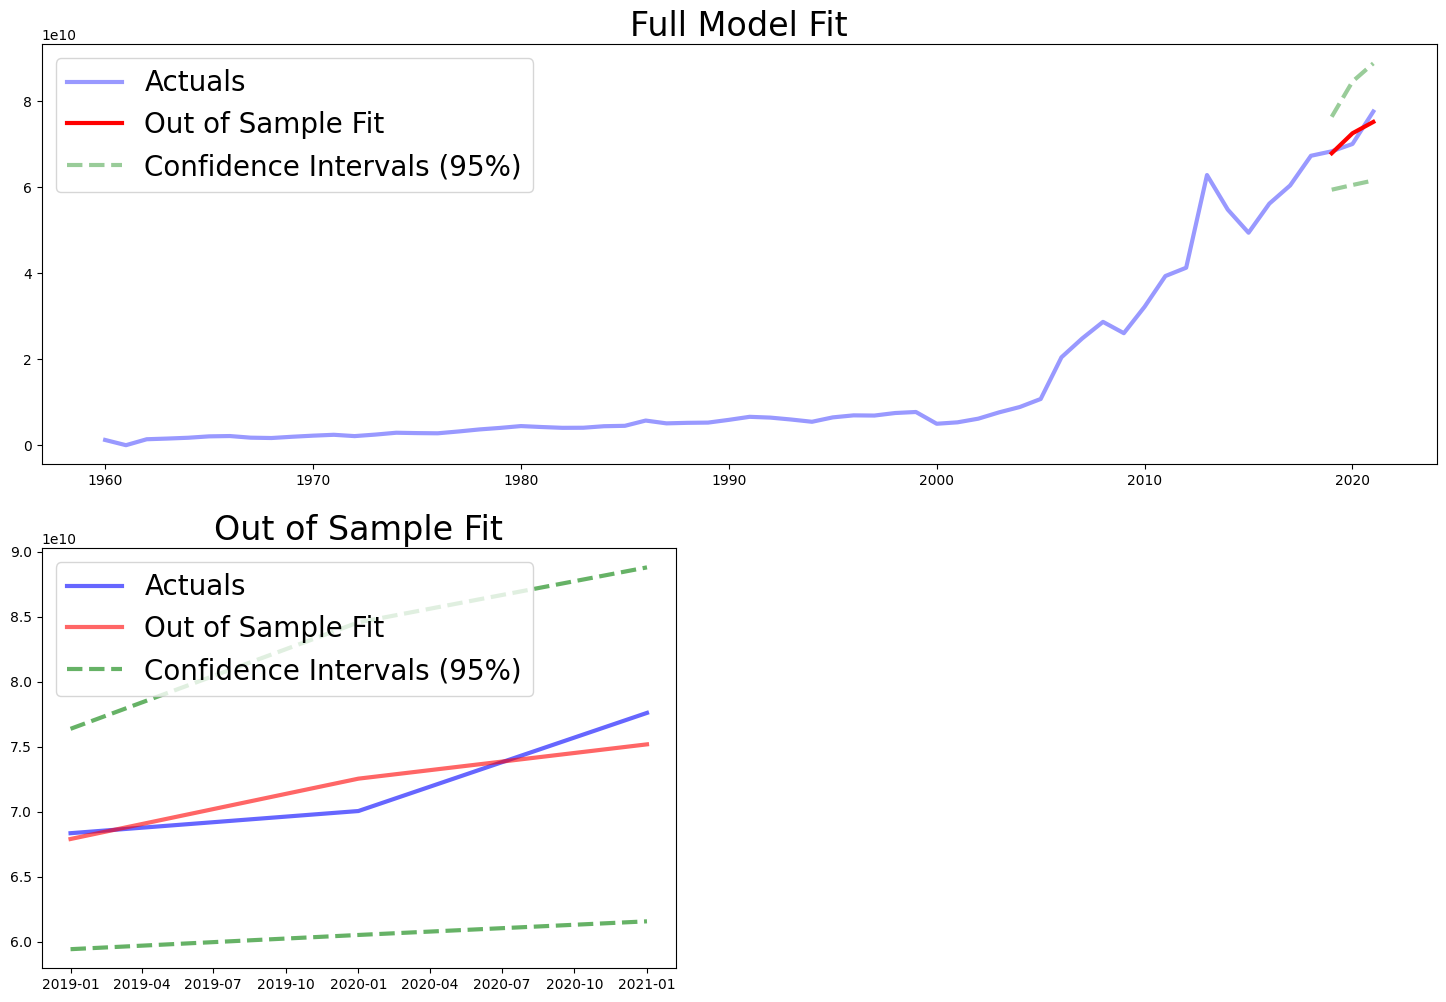

In [203]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

### В доверительный интервал попали. А вот предсказания как будто отзеркаленны

# Часть вторая сэмплирование и интерполяция

In [204]:
data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [205]:
data.isna().sum()

GDP (current US$)    0
dtype: int64

In [206]:
import numpy as np
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [207]:
data.isna().sum()

GDP (current US$)    1
dtype: int64

### Нет данных за 1961 год

In [208]:
data['GDP (current US$)'] = data['GDP (current US$)'].interpolate(method='linear')

In [209]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [210]:
test1 = adfuller(train_df["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980108
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [211]:
test1 = adfuller(train_df["GDP (current US$)"].diff(2).dropna())
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -3.99980344094915
p-value:  0.0014115408436661263
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


In [212]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=8,
    max_q=8,
    test="adf",
    error_action="ignore",
    trace=True,
    seasonal=False
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.28 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.28 sec


 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.14 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.24 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.971, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=2685.656, Time=0.26 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.584, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.921, Time=0.58 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.389, Time=0.35 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.513, Time=0.42 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2687.184, Time=0.11 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.393, Time=0.90 sec
 ARIMA(1,2,4)(0,0,0)[0]       

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 11 Sep 2023   AIC                           2680.513
Time:                        16:34:14   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+55. Standard errors may be unstable.
"""

### Индекс Акаике немного уменьшился 2680.513 был 2680.765

In [213]:
arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 11 Sep 2023   AIC                           2680.513
Time:                        16:34:15   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+55. Standard errors may be unstable.
"""

### Задание из юнита 8

In [214]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

In [215]:
train_test_groups = tscv.split(data) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


#### Волатильность

In [216]:
#pip install arch

In [217]:
data["GDP (current US$)"] = data["GDP (current US$)"].pct_change(1).mul(100).abs()
data["GDP (current US$)"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP (current US$), dtype: float64

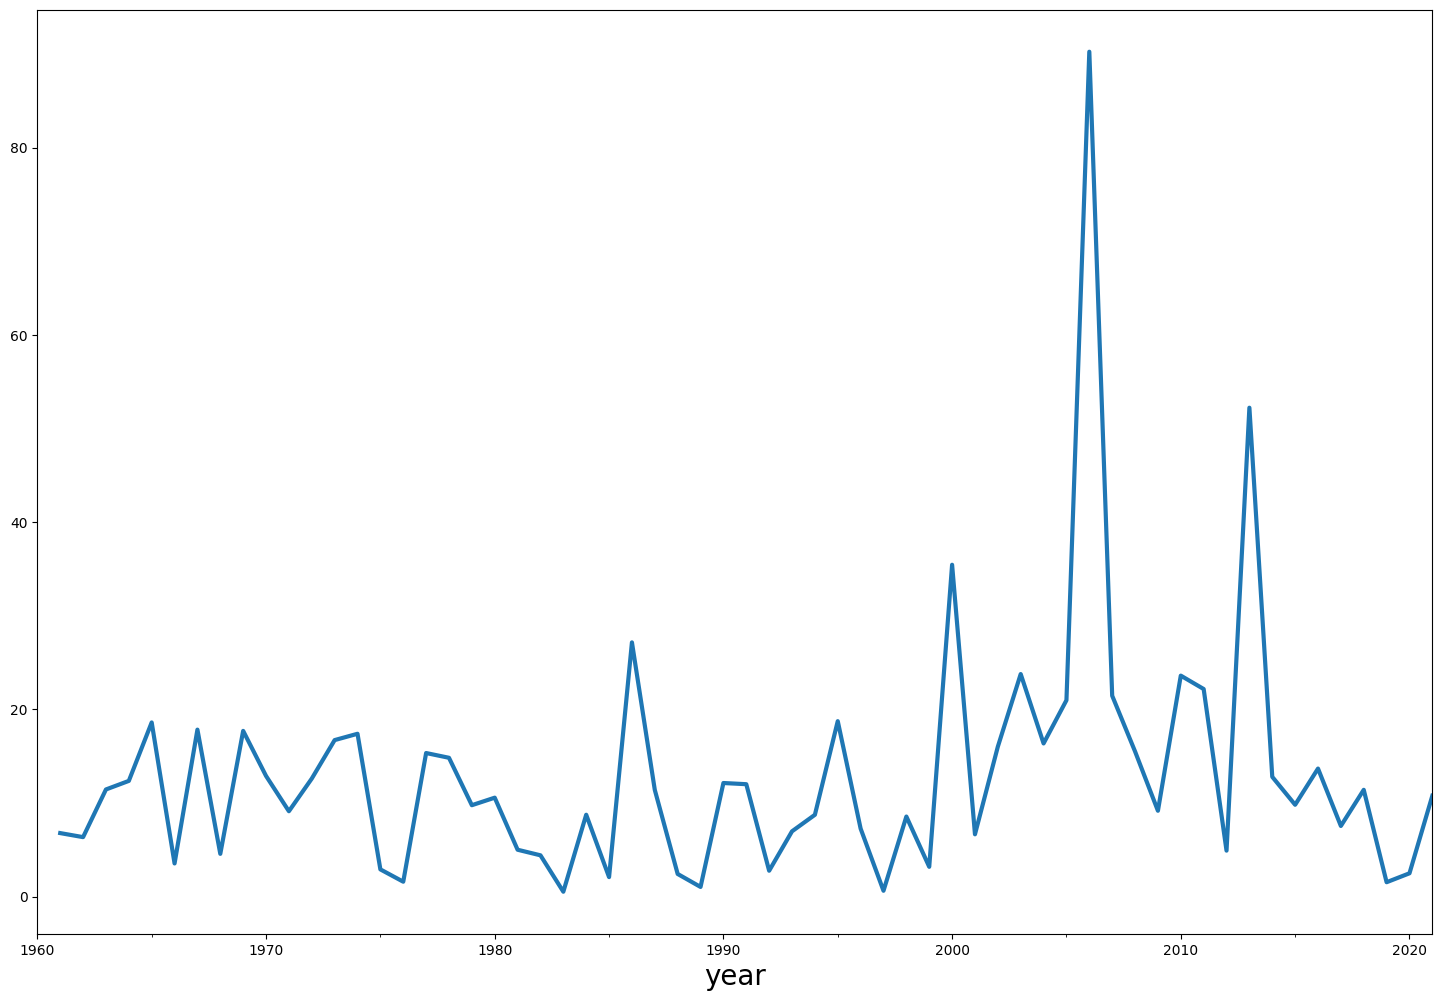

In [218]:
data["GDP (current US$)"].plot()
plt.show()

In [219]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

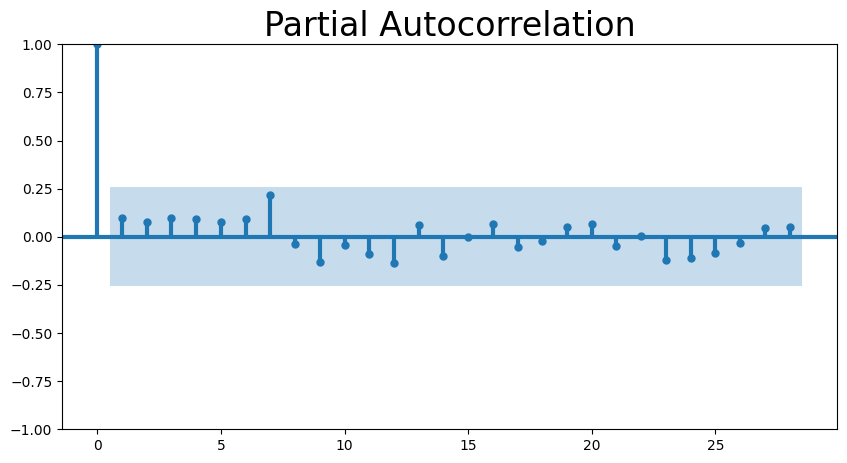

In [220]:
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df["GDP (current US$)"][1:], lags=28, method="ywm")
plt.show()

In [221]:
test1 = adfuller(train_df["GDP (current US$)"][1:])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -6.725311059553777
p-value:  3.4014596148856737e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


### В данной ситуации выбираем лаг равный 1

In [222]:
#нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data["GDP (current US$)"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "GDP (current US$)"] = train_df["GDP (current US$)"].dropna()

In [225]:
from arch import arch_model

model = arch_model(garch_df["GDP (current US$)"].dropna(), p=1, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18793168771535
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4897.458113019623
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.0018611399729
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.59783393778517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233127643
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [226]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:      GDP (current US$)   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Mon, Sep 11 2023   Df Residuals:                       57
Time:                        16:54:45   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.791  1.663e-06 [  7.279, 17.359]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.737      0.148      0.882 [-44.813, 52.153]
alpha[1]       0.0000  9.201e-02      0.000      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.722e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [227]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

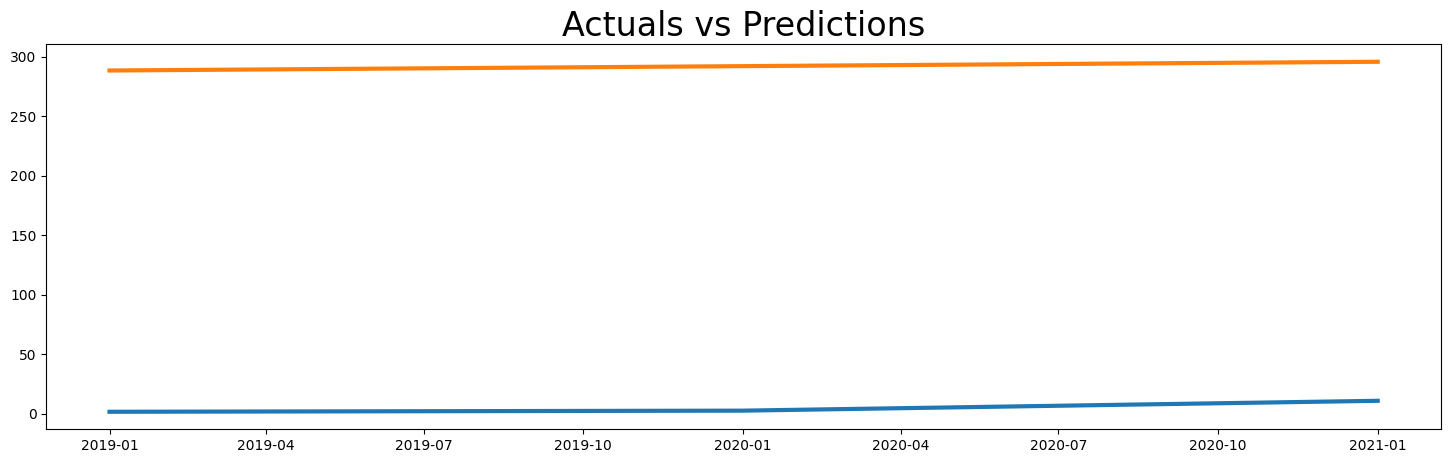

In [236]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP (current US$)"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions", size=24)

plt.show()

### Получилась какая-то кракозябра, не знаю почему так. 

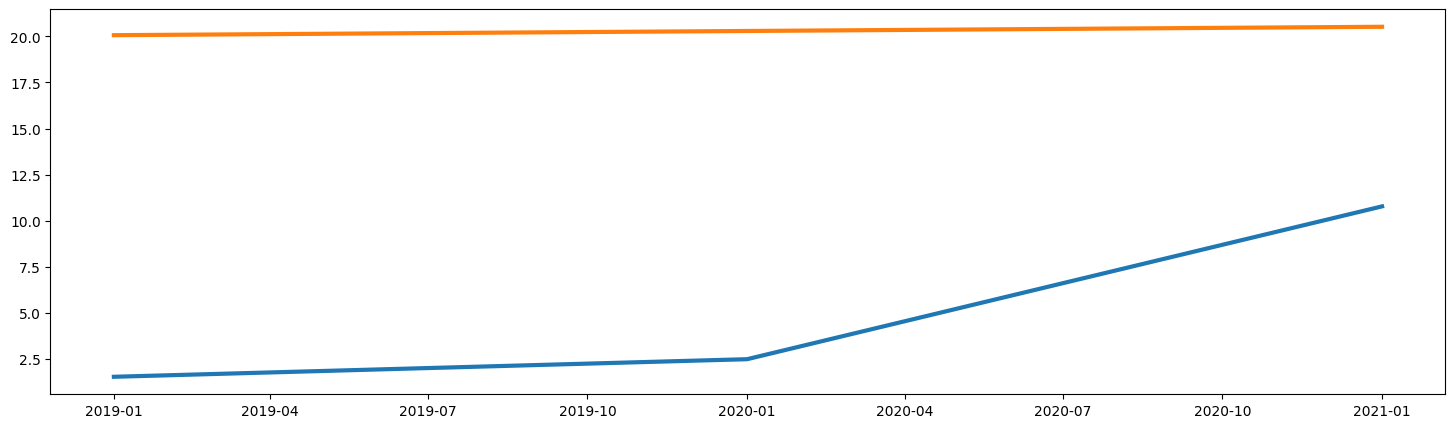

In [232]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["GDP (current US$)"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["GDP (current US$)"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP (current US$)"].fillna(0)
y_test = test_df["GDP (current US$)"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

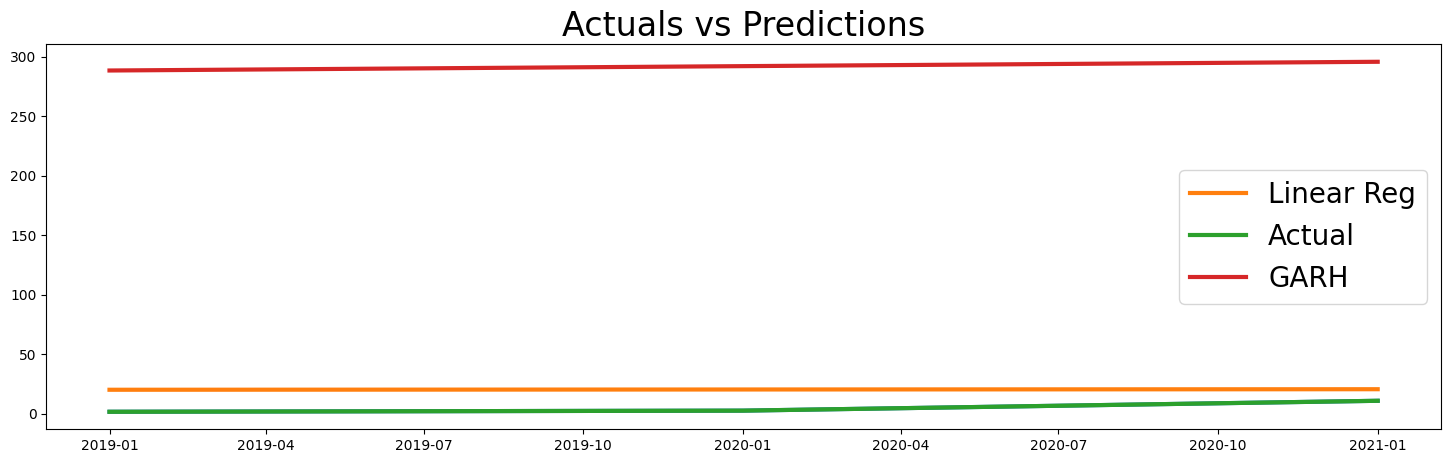

In [237]:
plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index), label = 'Linear Reg')

plt.plot(predictions_df["GDP (current US$)"].abs(), label = 'Actual')
plt.plot(predictions_df["Predictions"], label = 'GARH')

plt.title("Actuals vs Predictions", size=24)
plt.legend()
plt.show()

### Линейная регрессия показала лучшие результаты.
Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. В примере из скринкаста был противоположный результат, так как имелось больше данных и в обучающей выборке были случаи и возрастания, и убывания дисперсии, что удалось уловить модели.